In job_selection.ipynb we used spacy to get the cosine similiarity score
Here we are using using tf/idf

In [1]:
import pandas as pd
import os, glob, re
from glob import glob
from bs4 import BeautifulSoup
import logging, importlib, sys, tqdm
import pickle
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from _pckle import save_pickle_object, load_pickle_object
from _logging import set_logging
from _save_file import save_file
from _graph import histplot_count, histplot_range_count
from _utility import gl
from _statistics import get_summary_statistics

set_logging(logging)
df_jobs = load_pickle_object(gl.pkl_df_jobs_file)

ImportError: cannot import name 'get_summary_statistics' from '_statistics' (unknown location)

In [ ]:
def get_resume(file):
    clean_resume = lambda x: x.replace("\n", " ")
    
    file_path = os.path.join("Files\\UserInput", file)
    f = open(file_path, "r")
    resume_text = f.read()
    return clean_resume(resume_text)

In [ ]:
def add_cosine_dataframe_column(df, tag, matrix_cosine_similarity):
    cosine_similarity = matrix_cosine_similarity.toarray()
    column_name = f"{tag}_Cosine_Similarity"
    df[column_name] = 0.0
    for j, (id, row) in enumerate(df.iterrows()):
        if j < len(cosine_similarity):
            df.at[id, column_name] = cosine_similarity[j]
    return df

In [ ]:
def add_resume_to_jobs_dataframe(df_jobs):
    resume_id = df_jobs[gl.id].max() + 1
    resume_title = "resume"
    resume_text = get_resume(gl.txt_resume)
    resume_score = 1
    df_jobs.loc[len(df_jobs.index)] = [resume_id, resume_title, resume_text, resume_text, resume_score]
    return df_jobs

In [ ]:
def find_important_words(df, tag, tfIdfVectorizer):
    # Get the Bag of Words (BoW) matrix
    tfIdf_matrix = tfIdfVectorizer.fit_transform(df[tag])
    matrix_cosine_similarity = tfIdf_matrix[:-1] @ tfIdf_matrix[-1].T
    df = add_cosine_dataframe_column(df, tag, matrix_cosine_similarity)
    return df

In [ ]:
df_jobs = add_resume_to_jobs_dataframe(df_jobs)

tfIdfVectorizer=TfidfVectorizer(use_idf=True, 
                                lowercase=True,
                                #max_df=0.8,
                                #min_df=2,
                                #ngram_range=(1,3),
                                stop_words="english", 
                                )
list_tag = [gl.body, gl.bullet_points]
list_tfIdf = []
for tag in list_tag:
    df = find_important_words(df_jobs, tag, tfIdfVectorizer)




Output saved to file Files\Output\df_tfidf_jobs.csv


In [ ]:
save_file(gl.tfidf_file, df)
print("Summary Statistics for all of the jobs")
print("--------------------------------------")
get_summary_statistics(df, df_jobs)

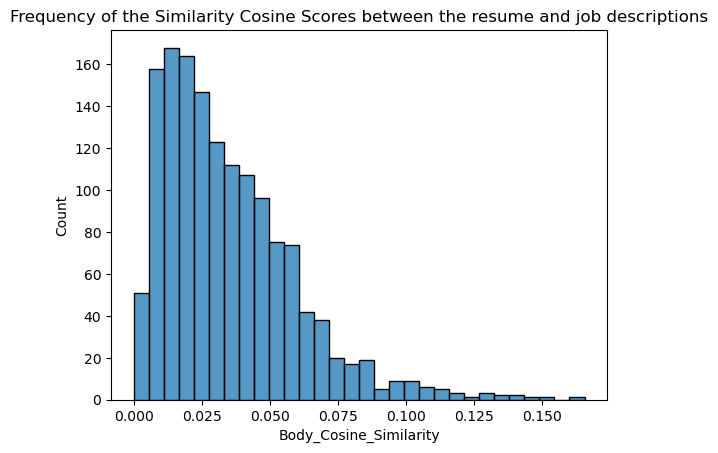

In [ ]:
title = "Frequency of the Similarity Cosine Scores between the resume and job descriptions"
histplot_count(title, df_jobs, gl.body_cos)

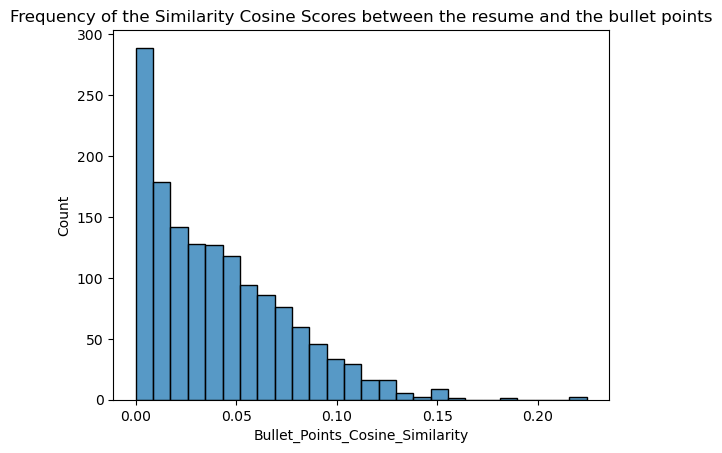

In [ ]:
title = "Frequency of the Similarity Cosine Scores between the resume and the bullet points"
histplot_count(title, df_jobs, gl.bullet_points_cos)

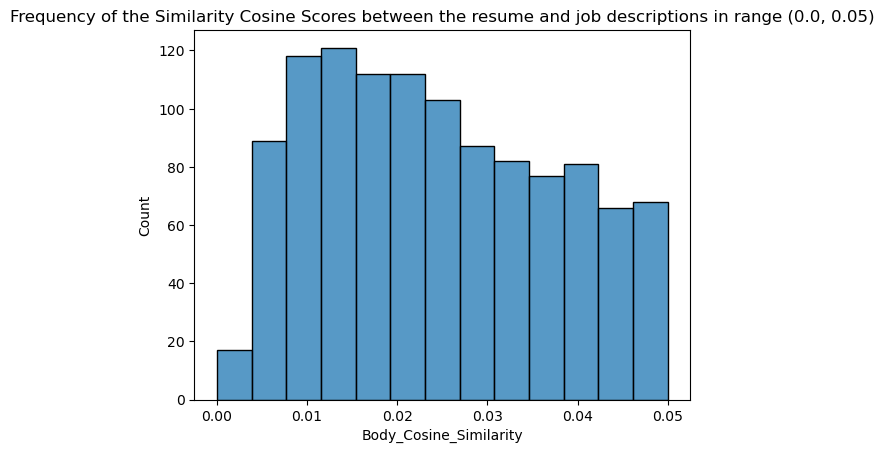

In [ ]:
cos_range = (0.0, 0.05)
title = f"Frequency of the Similarity Cosine Scores between the resume and job descriptions in range {cos_range}"
histplot_range_count(title, df_jobs, gl.body_cos, cos_range)

In [ ]:
save_pickle_object(df_jobs, gl.pkl_df_tfidf_jobs)
score_threshold = 0.01
df_selected_jobs = df_jobs.loc[df_jobs[gl.body_cos] > score_threshold]
df_not_selected_jobs = df_jobs.loc[df_jobs[gl.body_cos] <= score_threshold]
no_jobs = len(df_jobs)
no_selected_jobs = len(df_selected_jobs)
message = f"Number of job descriptions = {no_jobs}. After filtering there are {no_selected_jobs} left"
logging.info(message)
save_pickle_object(df_selected_jobs, gl.pkl_df_tfidf_selected_jobs)
save_pickle_object(df_not_selected_jobs, gl.pkl_df_tfidf_not_selected_jobs)

2023-01-01 16:33:38,427 | INFO : Saving pickle file from: pickle\pkl_df_tfidf_jobs.pkl


In [ ]:
print("Summary Statistics for Selected Jobs")
print("------------------------------------")
get_summary_statistics(df_selected_jobs, df_jobs)

In [ ]:
print("Summary Statistics for NOT Selected Jobs")
print("----------------------------------------")
get_summary_statistics(df_not_selected_jobs, df_jobs)